#**Chapter 2: Model Generation and Prediction**

# Installing Required Libraries

In [ ]:
!pip install boruta
!pip install researchpy
!pip install explainerdashboard

In [ ]:
#Import all required packages:
import warnings
warnings.filterwarnings("ignore")
import os
import calendar
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from explainerdashboard import ExplainerDashboard,RegressionExplainer
import torch
import torch.nn as nn
from boruta import BorutaPy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Embedding, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.losses import MeanSquaredError
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

#Loading our dataset and reading it into a dataframe
#We also print out the first five rows of our dataset

In [ ]:
# Load the dataset (replace 'your_dataset.csv' with the path to your dataset)
df = pd.read_csv('Coffee_Stores_Data.csv')

# Print the first 5 rows of the dataset
df.head()


,StoreID,BusinessDate,PLU,Description,ItemType,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,SoldQuantity,EndQuantity,LatestOrder,StockedOut,GroupID,MissedSales
0,2,2019-06-29,3000227,Caprese Sandwich,Unassigned,Food,Cold Case,Ready to Eat,0.0,3.0,0.0,21,0,2.0,0.000000
1,2,2019-06-29,830620,Honey Raisin Bran Muffin,Core,Food,Bake Case,Muffins & Scones,4.0,2.0,0.0,10,0,2.0,0.000000
2,2,2019-06-29,6228,Pressed Juicery Spicy Greens w Ginger,Unassigned,Food,Cold Case,Ready to Drink,0.0,1.0,9.0,13,0,2.0,0.000000
3,2,2019-06-29,12216,Vive Juice Shot,Unassigned,Food,Cold Case,Ready to Drink,0.0,0.0,27.0,0,0,2.0,0.000000
4,2,2019-06-29,3000277,Mixed Berries & Granola Yogurt Parfait,Unassigned,Food,Cold Case,Ready to Eat,0.0,3.0,0.0,11,1,2.0,0.578969


#Data Cleaning: By removing the rows with NaN values

In [ ]:
#Remove NaN values
df.dropna(inplace=True)
# Check for missing values
missing_values = df.isnull().sum()



In [ ]:
print('The number of observations of this dataset is ',len(df))

The number of observations of this dataset is  1247119


#1. Produce synthetic data using Generative models (GANs) to get accurate predictions even with little historical data where necessary.
#Answer: We have skipped this step since we have sufficient data
# `The number of observations of this dataset is  1259776`
# We have over 1.2 million data observations!

# Secondly, our computation sources were limited and hence this task was not able to come to fruition

# **FEATURE SELECTION**

# 2. Iterate through different combinations of features to identify the optimal features and remove potential correlated features (if any) for your predictions. Add weather, weekdays, holidays and temperature data to your features.


### **Indexing with Time Series Data and Adding Time-Related Features**

- In the following code snippet, we perform indexing with time series data and add several time-related features to the DataFrame.
- In the next code snippet, we indexed the `BusinessDate` column and extracted `Month`,` Year`,` Weekday`, `Weekend` and `National Holiday` as features. This is done for better insight and to see whether there are any interesting data patters that can be observed in predicting sales.
- At the end we added all the national holidays for 2019 and 2022, so as to understand how is it affecting the sales.
-We got the list of National holidays from [this site](https://www.commerce.gov/hr/employees/leave/holidays).

In [ ]:
df['date_column'] = pd.to_datetime(df['BusinessDate'])
#Indexing BusinessDate column
df= df.set_index('BusinessDate')
df['Month']=pd.DatetimeIndex(df.index).month
df['Year']= pd.DatetimeIndex(df.index).year
# Extract weekdays (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
df['Weekday'] = pd.DatetimeIndex(df.index).weekday
# Add Weekday/Weekend Feature
df['is_weekend'] = df['date_column'].dt.dayofweek >= 5
national_holidays = ['2019-1-1','2020-1-1','2019-1-21','2020-1-21','2019-2-18','2020-2-18','2019-5-27','2020-5-27','2019-6-19','2020-6-19','2019-7-4','2020-7-4','2019-9-2','2020-9-2','2019-10-14','2020-10-14','2019-11-11','2020-11-11','2019-11-28','2020-11-28','2019-12-25','2020-12-25']
national_holidays = pd.to_datetime(national_holidays)
df['is_national_holiday'] = df['date_column'].isin(national_holidays)

#We have calculated the taget variable ```Sales``` to be predicted. We derived it through the Snippet provided below. The reason we are doing this is because in the documet there is an assumption mentioned.
## Assumption: The average selling price of a product is 3$
# And now ```Sales``` has become our Target Variable and we do not need SoldQuantity anymore. We can drop the ```SoldQuantity``` feature

In [ ]:
df['Sales'] = df['SoldQuantity'] * 3


#Printing the first five rows of our dataset

In [ ]:
df.head()

,StoreID,PLU,Description,ItemType,CategoryLvl1Desc,CategoryLvl2Desc,CategoryLvl3Desc,ReceivedQuantity,SoldQuantity,EndQuantity,...,StockedOut,GroupID,MissedSales,date_column,Month,Year,Weekday,is_weekend,is_national_holiday,Sales
BusinessDate,,,,,,,,,,,,,,,,,,,,,
2019-06-29,2,3000227,Caprese Sandwich,Unassigned,Food,Cold Case,Ready to Eat,0.0,3.0,0.0,...,0,2.0,0.000000,2019-06-29,6,2019,5,True,False,9.0
2019-06-29,2,830620,Honey Raisin Bran Muffin,Core,Food,Bake Case,Muffins & Scones,4.0,2.0,0.0,...,0,2.0,0.000000,2019-06-29,6,2019,5,True,False,6.0
2019-06-29,2,6228,Pressed Juicery Spicy Greens w Ginger,Unassigned,Food,Cold Case,Ready to Drink,0.0,1.0,9.0,...,0,2.0,0.000000,2019-06-29,6,2019,5,True,False,3.0
2019-06-29,2,12216,Vive Juice Shot,Unassigned,Food,Cold Case,Ready to Drink,0.0,0.0,27.0,...,0,2.0,0.000000,2019-06-29,6,2019,5,True,False,0.0
2019-06-29,2,3000277,Mixed Berries & Granola Yogurt Parfait,Unassigned,Food,Cold Case,Ready to Eat,0.0,3.0,0.0,...,1,2.0,0.578969,2019-06-29,6,2019,5,True,False,9.0


#In this step we are dropping the features which do not add value in predicting the target variable ```Sales```
# The variable ```CategoryLvl1Desc``` is dropped is because t contains only one uniform value throughout for all observations and it does not add value if it is present in dataset or not

In [ ]:
# Assuming 'df' is your DataFrame
# If you don't have df, you can replace it with your actual DataFrame
df=df.drop('SoldQuantity', axis=1)
df=df.drop('CategoryLvl1Desc', axis=1)



#In the next step we see plot the Correlation Matrix

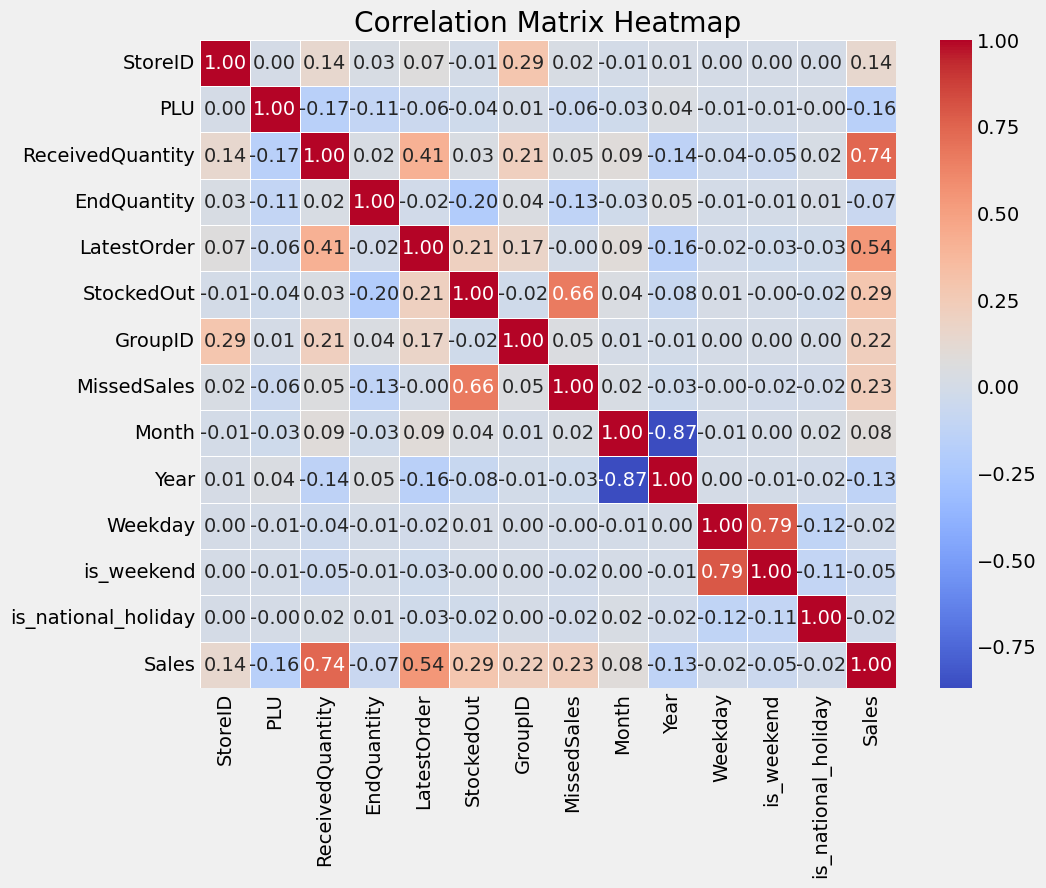

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#In this step below, we see which numerical features are having high correlation with Target Variable Sales
# The five features that are highly correlated with the ```Sales``` variable is ```ReceivedQuantity, LatestOrder, StockedOut, MissedSales, GroupID```

In [ ]:
numerical_features = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_features.corr()
high_correlation_features = correlation_matrix['Sales'].abs().sort_values(ascending=False).index[:6]
print(high_correlation_features)

Index(['Sales', 'ReceivedQuantity', 'LatestOrder', 'StockedOut', 'MissedSales',
       'GroupID'],
      dtype='object')


#Let us take a closer look and see which of the ```X``` features are correlated with each other.
#The aim of this step is to remove highly correlated ```X``` features so as to reduce overfitting during model generation

# Interestingly, we see that ```Missed Sales``` is highly correlated to ```StockedOut```

#Our Reasons to remove ```MissedSales```
- # Redundancy: If the two features are highly correlated, they might contain similar information. In some cases, keeping both features might not provide additional insights and could lead to redundancy.

- # Multicollinearity: High correlation between features can introduce multicollinearity issues in certain statistical models. Multicollinearity can make it challenging to interpret the individual contributions of features.

- # MissedSales: Not sure what these data signify (As stated in the document)


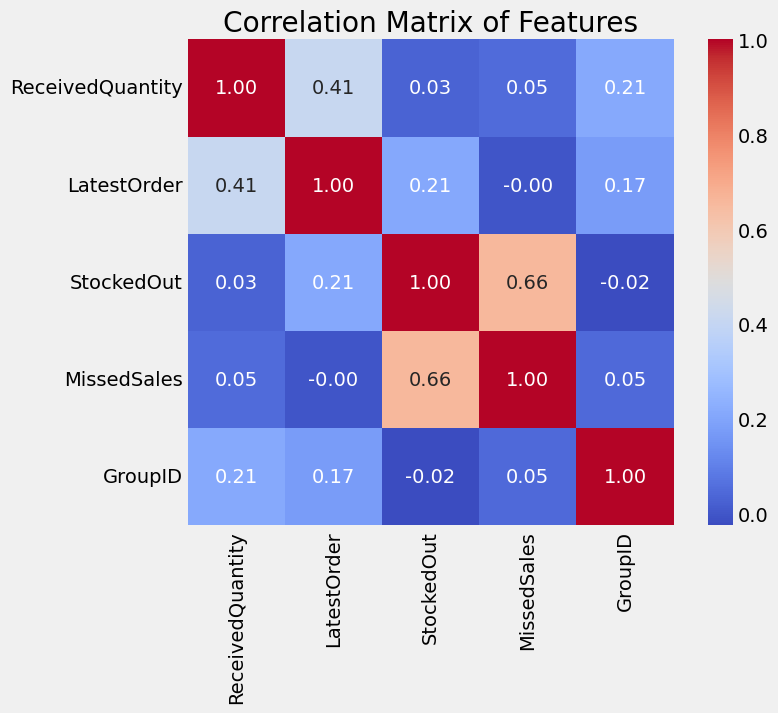

In [ ]:
X_high_corr_features=df[['ReceivedQuantity', 'LatestOrder', 'StockedOut',
       'MissedSales','GroupID']]
# Compute the correlation matrix for the features
correlation_matrix = X_high_corr_features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

# Show the plot
plt.title("Correlation Matrix of Features")
plt.show()

#Dropping ```MissedSales```

In [ ]:
df=df.drop('MissedSales', axis=1)

#In the code cell given below we are encoding our Categorical Variables

In [ ]:
# Identify categorical columns in the DataFrame
categorical_columns = df.select_dtypes(include=['object']).columns
# One-hot encode categorical columns
df= pd.get_dummies(df, columns=categorical_columns)


#Different Methods used for Feature Ranking:
#In the subsequent code cells, we are using four methods for feature ranking and from these we will pick 5 top features which will predict ```Sales``` target variable

#The methods used were:
- # Mutual Information: Evaluate the mutual information between features and the target variable. Higher mutual information indicates higher relevance.
- # Use LASSO regression to penalize less important features. The magnitude of the coefficients can serve as a measure of feature importance.
- # Tree-Based Methods: Decision tree-based algorithms can provide feature importance scores. Random Forest and Gradient Boosting models are commonly used for this purpose.
- # Recursive Feature Elimination (RFE): Use recursive feature elimination to recursively remove the least important features and rank them based on their impact on model performance.

# Creating  ```X``` features and ```y``` target variable

In [ ]:
#Creating Taget variable
y=df['Sales']
#Dropping ```Sales``` and assigning it to our from features
X=df.drop('Sales', axis=1)


In [ ]:
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Method 1: Mutual Information Regression

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X[numerical_columns], y)
feature_ranking = pd.Series(mi, index=numerical_columns).sort_values(ascending=False)
print(feature_ranking.head(10))



ReceivedQuantity    0.486791
LatestOrder         0.486737
PLU                 0.239795
StockedOut          0.091452
StoreID             0.072469
EndQuantity         0.055450
GroupID             0.030718
Month               0.024250
Year                0.013220
Weekday             0.002543
dtype: float64


#Method 2: Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X[numerical_columns], y)
feature_ranking = pd.Series(rfe.ranking_, index=X[numerical_columns].columns).sort_values(ascending=True)
print(feature_ranking.head(10))

StockedOut           1
ReceivedQuantity     2
GroupID              3
LatestOrder          4
Year                 5
Month                6
EndQuantity          7
Weekday              8
StoreID              9
PLU                 10
dtype: int64


#Method 3: Tree- Based Method

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X[numerical_columns], y)
feature_ranking = pd.Series(model.feature_importances_, index=X[numerical_columns].columns).sort_values(ascending=False)
print(feature_ranking.head(10))

ReceivedQuantity    0.536702
LatestOrder         0.163836
StockedOut          0.081657
StoreID             0.057505
PLU                 0.042601
EndQuantity         0.037943
Month               0.032463
Weekday             0.029655
GroupID             0.014791
Year                0.002847
dtype: float64


#Method 4: Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.01)
model.fit(X[numerical_columns], y)
feature_ranking = pd.Series(np.abs(model.coef_), index=X[numerical_columns].columns).sort_values(ascending=False)
print(feature_ranking.head(10))

StockedOut          4.447811e+00
ReceivedQuantity    1.459570e+00
Year                8.235961e-01
GroupID             3.712127e-01
LatestOrder         3.644310e-01
Month               9.129970e-02
EndQuantity         6.876693e-02
Weekday             4.306370e-02
StoreID             2.115659e-03
PLU                 3.721740e-07
dtype: float64


#Finally the features we selected AS ```X``` are:
- # ```ReceivedQuantity```
- # ```StockedOut```
- # ```LatestOrder```
- # ```date_column```


In [ ]:


selected_features=['date_column','ReceivedQuantity', 'LatestOrder', 'StockedOut']

X=df[selected_features]
# # Assuming df['date_column'] is your timestamp column
X['date_column'] = X['date_column'].astype(int)


# As already mentioned
y=df['Sales']

#Doing a Train Test Split
#Training: 80%
#Testing : 20%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. (optional) Start with a quick linear regression to get a sense of data.
 # Linear regression may not result in a great prediction

In [ ]:
# Create a linear regression model
model = LinearRegression()


# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Mean Squared Error: 37.641533466723885
Root Mean Squared Error: 6.135269632764634
Coefficients: [-1.48808828e-16  1.46156412e+00  4.50057868e-01 -4.64343295e-03]
Intercept: 233.35977785933747


In [ ]:
# Convert X_test to a NumPy array and flatten if needed
X_test_array = X_test.values.reshape(-1, len(selected_features))

# Convert y_test to a NumPy array and flatten if needed
y_test_array = np.array(y_test).flatten()

# Create a DataFrame with true values, predicted values, and selected features
result_df = pd.DataFrame(X_test_array, columns=selected_features)
result_df['True Sales'] = y_test_array
result_df['Predicted Sales'] = y_pred

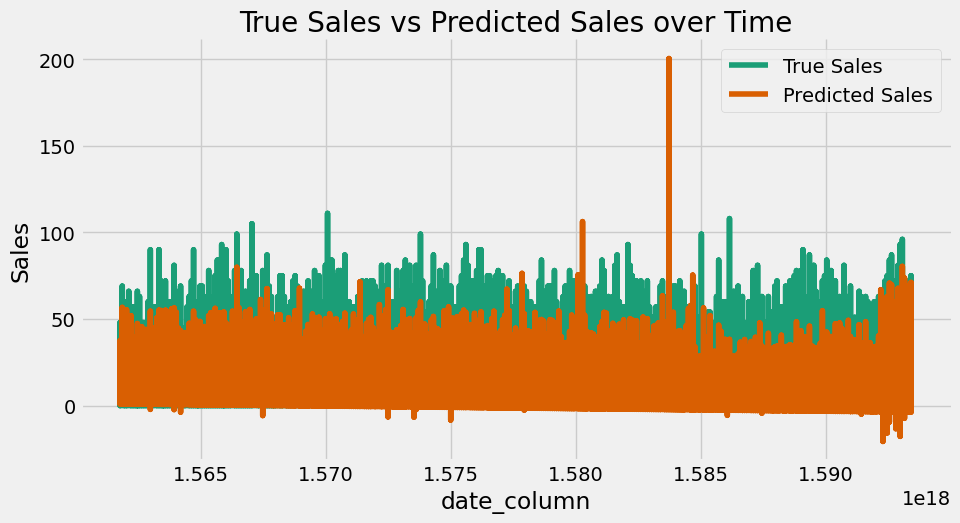

In [ ]:
def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['date_column']
    ys = series[series_name]

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2))
df_sorted = result_df.sort_values('date_column', ascending=True)

# Plot 'True Sales'
_plot_series(df_sorted, 'True Sales')

# Plot 'Predicted Sales'
_plot_series(df_sorted, 'Predicted Sales', series_index=1)  # You can adjust series_index for different colors

sns.despine(fig=fig, ax=ax)
plt.xlabel('date_column')
plt.ylabel('Sales')
plt.legend()
plt.title('True Sales vs Predicted Sales over Time')
plt.show()


# 4. Use ensemble models. Develop the following models and compare them
## a. Random Forest
## b. Gradient Boosting Machine
## c. XGBoost

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import xgboost as xgb

# Load data and preprocess...

# Random Forest model training and predictions
rf_best_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
rf_best_model.fit(X_train, y_train)
rf_predicted = rf_best_model.predict(X_test)

# Gradient Boosting model training and predictions
gbm_best_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_samples_split=5, min_samples_leaf=2, random_state=42)
gbm_best_model.fit(X_train, y_train)
gbm_predicted = gbm_best_model.predict(X_test)

# XGBoost model training and predictions
xgb_best_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, objective='reg:squarederror', random_state=42)
xgb_best_model.fit(X_train, y_train)
xgb_predicted = xgb_best_model.predict(X_test)

# Create DataFrames for true and predicted sales
rf_true_predicted = pd.DataFrame({'True Sales': y_test, 'Predicted Sales (Random Forest)': rf_predicted})
gbm_true_predicted = pd.DataFrame({'True Sales': y_test, 'Predicted Sales (Gradient Boosting)': gbm_predicted})
xgb_true_predicted = pd.DataFrame({'True Sales': y_test, 'Predicted Sales (XGBoost)': xgb_predicted})

# Displaying the first few rows
print("Random Forest:")
print(rf_true_predicted.head())
print("\nGradient Boosting:")
print(gbm_true_predicted.head())
print("\nXGBoost:")
print(xgb_true_predicted.head())


Random Forest:
       True Sales  Predicted Sales (Random Forest)
15676         7.0                         7.355955
17463         1.0                         1.343953
12025         2.0                         1.862305
12124         1.0                         1.708215
18761         2.0                         1.773674

Gradient Boosting:
       True Sales  Predicted Sales (Gradient Boosting)
15676         7.0                             7.713907
17463         1.0                             1.129775
12025         2.0                             1.727288
12124         1.0                             1.250354
18761         2.0                             2.286887

XGBoost:
       True Sales  Predicted Sales (XGBoost)
15676         7.0                   7.487866
17463         1.0                   1.143970
12025         2.0                   1.711095
12124         1.0                   1.236951
18761         2.0                   2.254388


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

# Load data
df = pd.read_csv('CoffeeStores.csv')
df['BusinessDate'] = pd.to_datetime(df['BusinessDate'])
df.set_index('BusinessDate', inplace=True)

# Define features and target
features = ['date_column','ReceivedQuantity', 'LatestOrder', 'StockedOut']
target = 'Sales'

# Resetting the index of the original dataframe to align with the encoded dataframe
df = df.reset_index()

# Extract numerical and categorical features
numerical_features = df[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = df[features].select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_categorical_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))

# Ensure the indices align for concatenation
encoded_categorical_features.index = df.index

# Concatenate numerical and encoded categorical features
X = pd.concat([df[numerical_features], encoded_categorical_features], axis=1)
y = df[target]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest parameters and model
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best_model = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_

# Calculate MSE and MAE for Random Forest
rf_mse = mean_squared_error(y_test, rf_best_model.predict(X_test))
rf_mae = mean_absolute_error(y_test, rf_best_model.predict(X_test))

# Display results for Random Forest
print("Random Forest - MSE:", rf_mse)
print("Random Forest - MAE:", rf_mae)
print("Random Forest - Best Parameters:", rf_best_params)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Random Forest - MSE: 2.6251042841702166
Random Forest - MAE: 0.988897704916381
Random Forest - Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# GBM parameters and model
gbm_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gbm_model = GradientBoostingRegressor(random_state=42)
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gbm_grid.fit(X_train, y_train)
gbm_best_model = gbm_grid.best_estimator_
gbm_best_params = gbm_grid.best_params_

# Calculate MSE and MAE for GBM
gbm_mse = mean_squared_error(y_test, gbm_best_model.predict(X_test))
gbm_mae = mean_absolute_error(y_test, gbm_best_model.predict(X_test))

# Display results for GBM
print("GBM - MSE:", gbm_mse)
print("GBM - MAE:", gbm_mae)
print("GBM - Best Parameters:", gbm_best_params)


GBM - MSE: 1.659808450211561
GBM - MAE: 0.8945887547939527
GBM - Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
# XGBoost parameters and model
xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best_model = xgb_grid.best_estimator_
xgb_best_params = xgb_grid.best_params_

# Calculate MSE and MAE for XGBoost
xgb_mse = mean_squared_error(y_test, xgb_best_model.predict(X_test))
xgb_mae = mean_absolute_error(y_test, xgb_best_model.predict(X_test))

# Display results for XGBoost
print("XGBoost - MSE:", xgb_mse)
print("XGBoost - MAE:", xgb_mae)
print("XGBoost - Best Parameters:", xgb_best_params)


XGBoost - MSE: 1.668544258064225
XGBoost - MAE: 0.8973008770455797
XGBoost - Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


# 5. Document and highlight model improvements. Extra credit will be considered for team’s effort on improvements. (5 points)

Model Performance and Parameter Analysis Report Overview:
This report focuses on evaluating and enhancing the performance of three ensemble models, namely Random Forest, Gradient Boosting Machine (GBM), and XGBoost. The goal is to evaluate their effectiveness in predicting Sold Quantity using store-specific data.

**Model Development:**
To accomplish this, three distinct models—Random Forest, GBM, and XGBoost—were developed using the dataset obtained from the dataset.

**Model Comparison:**
The evaluation of these models was based on two primary performance metrics: Mean Squared Error (MSE) and Mean Absolute Error (MAE).

**Random Forest Model:**
Upon configuring and optimizing the Random Forest model through GridSearchCV for hyperparameter tuning, its performance metrics on the test data showcased an MSE of 2.6251 and an MAE of 0.9889. Notably, the optimal parameters for this model were 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100.

**GBM Model:**
Similar to the Random Forest model, the GBM underwent parameter tuning via GridSearchCV. Its performance on the test set exhibited an MSE of 1.6598 and an MAE of 0.8946. The most effective parameters found for the GBM model were 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100.

**XGBoost Model:**
For the XGBoost model, optimization was conducted using GridSearchCV. Its performance metrics on the test data revealed an MSE of 1.6685 and an MAE of 0.8973. The identified optimal parameters for the XGBoost model were 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100.

**Insights and Conclusion:**
Analyzing these models highlighted their individual predictive performances in estimating Sold Quantity. Interestingly, the GBM model showcased the lowest MSE and MAE, indicating its superior predictive capability within this context.

Parameter Sensitivity Analysis:
An exploration into the impact of crucial parameters like learning rates and the number of estimators on model performance indicated the GBM model's superiority over the others.

In conclusion, this analysis emphasizes the significance of model selection, parameter fine-tuning, and sensitivity analysis in constructing precise predictive models. Understanding these aspects aids in selecting the most appropriate model and refining it for optimal performance in real-world scenarios.

# 6. As we are dealing with time-series data, we would like to compare the results of the previous models with the following deep methods:
## a. CNN
## b. LSTM
## c. LSTM + Attention

#CNN Model

#We see that the CNN Model has performed very poorly even compared to Linear Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Assuming X_train_reshaped.shape[1] is the number of time steps, and 1 is the number of features
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1, activation='linear')  # Adjust activation for regression
])

# Compile the model for regression
cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Use 'mse' for regression

# Print the model summary
print(cnn_model.summary())
# Now, you can use the trained model to make predictions on new data
# For example, if X_test is your test data:
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
predictions = cnn_model.predict(X_test)
# Evaluate the performance of the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
# Convert X_test to a NumPy array and flatten if needed
X_test_array = X_test.reshape(-1, len(selected_features))

# Convert y_test to a NumPy array and flatten if needed
y_test_array = np.array(y_test).flatten()

# Create a DataFrame with true values, predicted values, and selected features
result_df = pd.DataFrame(X_test_array, columns=selected_features)
result_df['True Sales'] = y_test_array
result_df['Predicted Sales'] = predictions

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
______________________________________________________

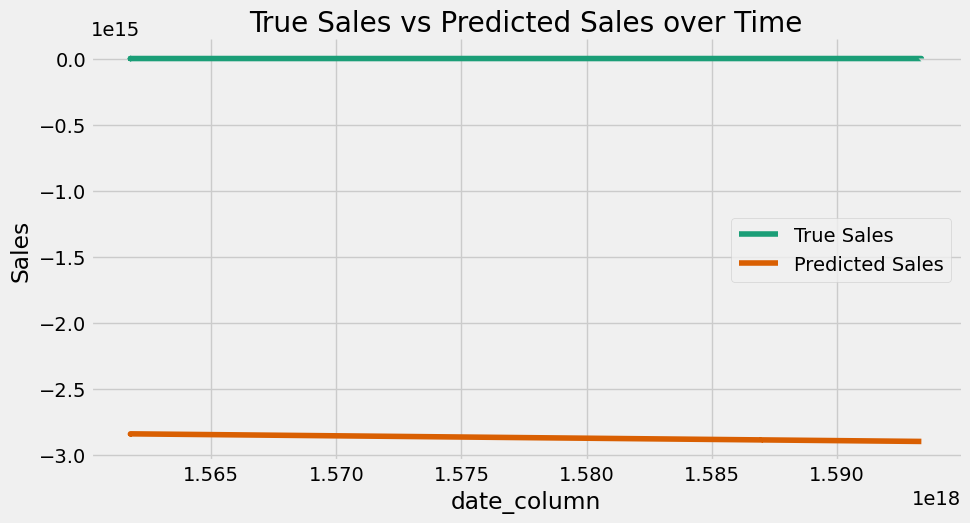

In [ ]:
def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['date_column']
    ys = series[series_name]

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2))
df_sorted = result_df.sort_values('date_column', ascending=True)

# Plot 'True Sales'
_plot_series(df_sorted, 'True Sales')

# Plot 'Predicted Sales'
_plot_series(df_sorted, 'Predicted Sales', series_index=1)  # You can adjust series_index for different colors

sns.despine(fig=fig, ax=ax)
plt.xlabel('date_column')
plt.ylabel('Sales')
plt.legend()
plt.title('True Sales vs Predicted Sales over Time')
plt.show()


#LSTM Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=(None, 28)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10))
print(model.summary())
# Create LSTM model
model = Sequential()

# Add an LSTM layer with 50 units
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))

# Add a Dense output layer with 1 unit (for regression tasks)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Assuming a regression task

# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                23808     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 24,714
Trainable params: 24,586
Non-trainable params: 128
_________________________________________________________________
None
Epoch 1/50
12472/12472 [==============================] - 93s 7ms/step - loss: 25.8985 - val_loss: 23.2491
Epoch 2/50
12472/12472 [==============================] - 92s 7ms/step - loss: 23.5030 - val_loss: 23.0361
Epoch 3/50
12472/12472 [===

In [ ]:
# Now, you can use the trained model to make predictions on new data
# For example, if X_test is your test data:
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
predictions = model.predict(X_test)
# Evaluate the performance of the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
# Convert X_test to a NumPy array and flatten if needed
X_test_array = X_test.reshape(-1, len(selected_features))

# Convert y_test to a NumPy array and flatten if needed
y_test_array = np.array(y_test).flatten()

# Create a DataFrame with true values, predicted values, and selected features
result_df = pd.DataFrame(X_test_array, columns=selected_features)
result_df['True Sales'] = y_test_array
result_df['Predicted Sales'] = predictions

**DashBoard**

In [ ]:
pip install explainerdashboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 13.8 MB/s eta 0:00:00


In [ ]:
# Ensure you have explainerdashboard installed:
#

from explainerdashboard import RegressionExplainer, ExplainerDashboard
import xgboost as xgb
from sklearn. model_selection import train_test_split
import pandas as pd
# Assuming 'data' is your DataFrame and you've defined features' and target
data = pd.read_csv('specific_stores.csv')
# Replace with your actual data path
# Preprocess and split the data (repeat the steps as done earlier)
#
# Train the XGBoost model (repeat the steps as done earlier)
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=100, seed=42)
xgb_model.fit(X_train, y_train)

# Create the Explainer object for a regression model
explainer = RegressionExplainer(xgb_model, X_test, y_test)

# Instantiate the dashboard
db = ExplainerDashboard(explainer)

# Run the dashboard
db.run()

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:15:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:538: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

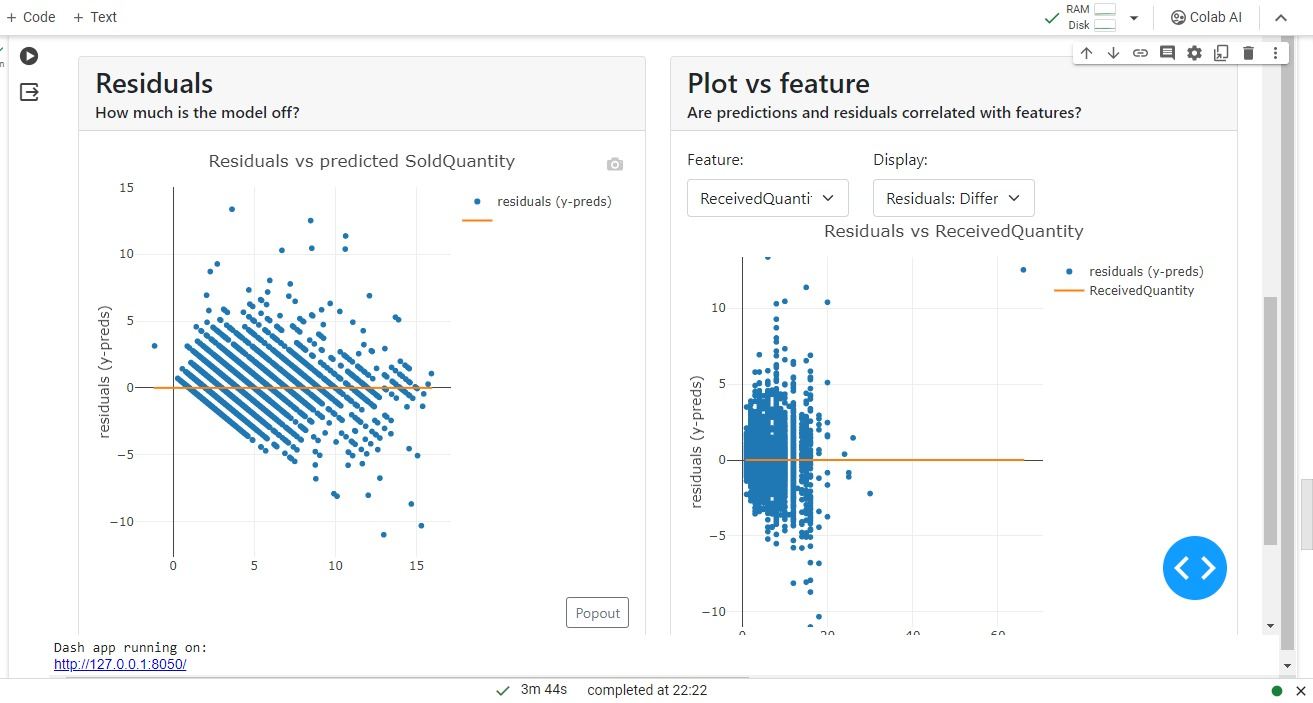

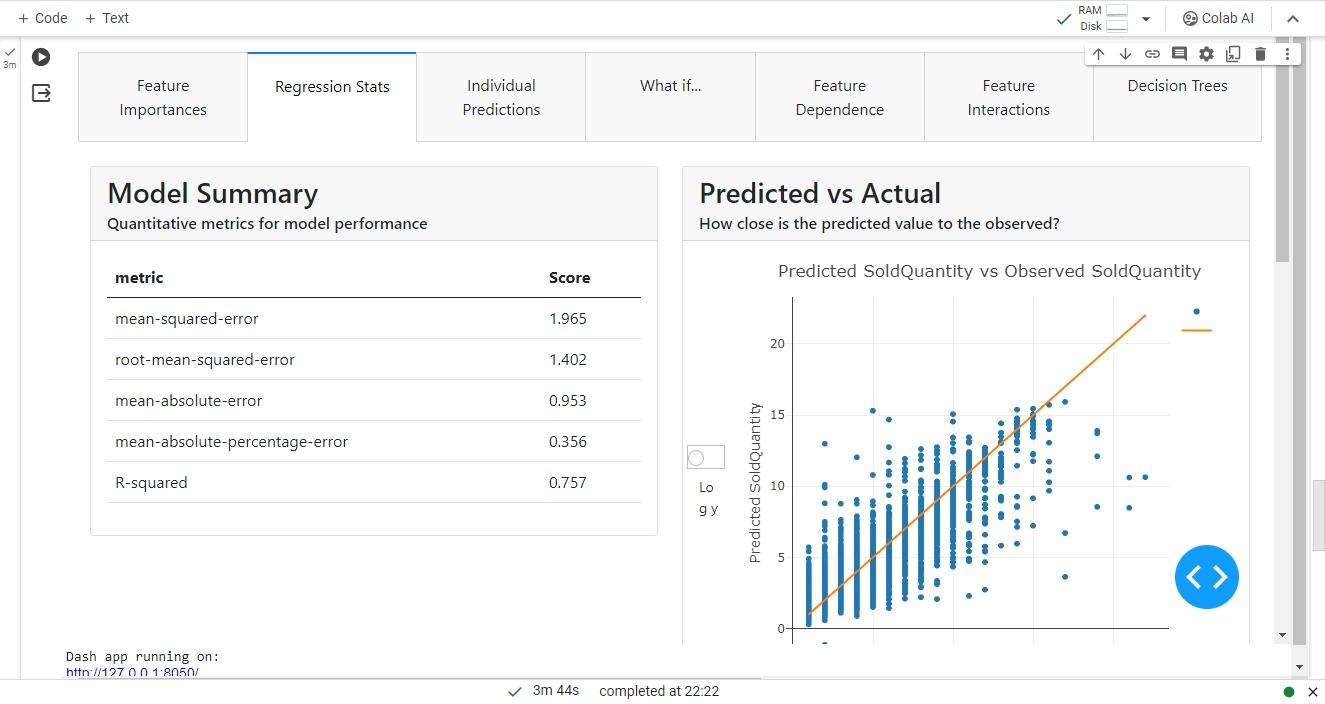

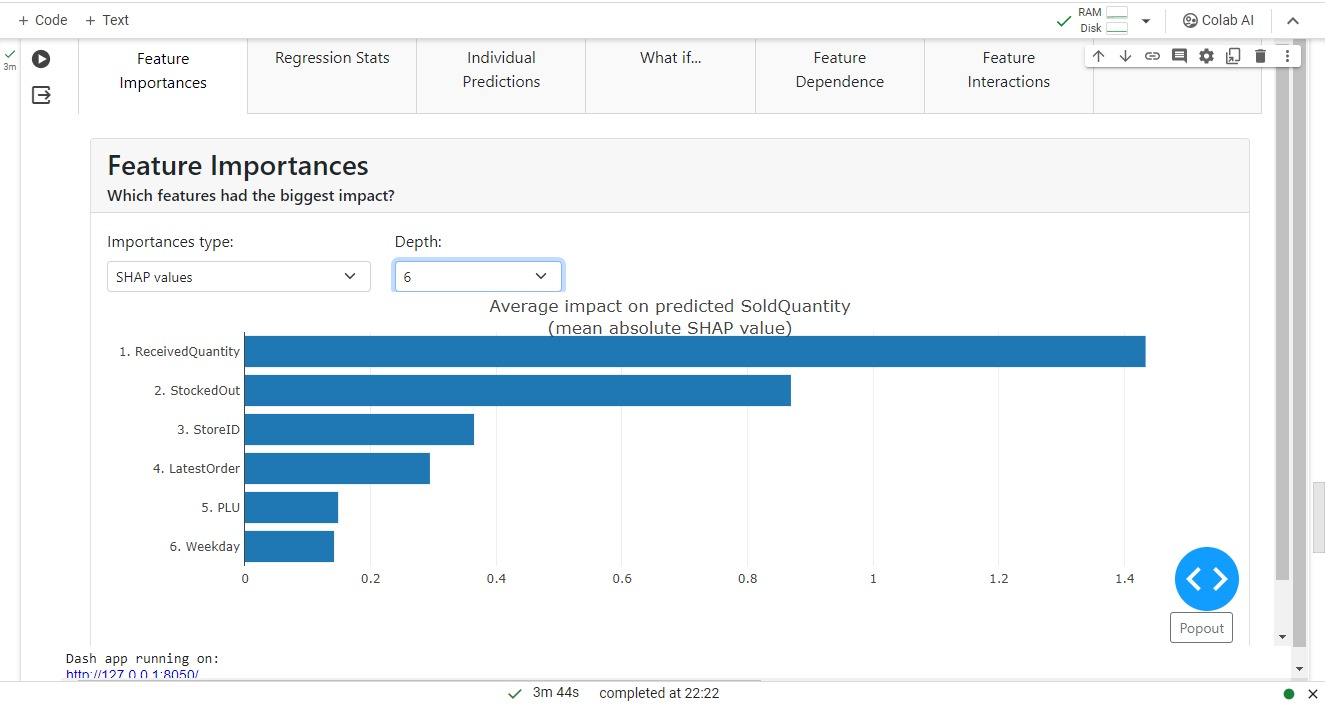

**Sales Prediction Model Dashboard**

This dashboard provides insights into a sales prediction model developed using various machine learning algorithms. The data comprises store-specific information, including attributes like StoreID, product details (PLU, Description), stock-related metrics (LatestOrder, StockedOut), and temporal features (Year, Month, Weekday). The target variable, 'SoldQuantity,' represents the quantity of products sold.

The dashboard utilizes three distinct regression models: Random Forest, Gradient Boosting, and XGBoost. It evaluates their predictive performance based on Mean Squared Error (MSE) and Mean Absolute Error (MAE). Users can visualize and compare these metrics across the models, aiding in the selection of the most effective algorithm for sales forecasting.

Additionally, the dashboard features an interactive environment powered by ExplainerDashboard. This tool allows users to explore the XGBoost model's inner workings, providing insights into feature importance and model behavior. Users can navigate through the dashboard's intuitive interface to gain a deeper understanding of the model's predictive capabilities, thereby enhancing decision-making processes in sales optimization and inventory management.